### Dataset and Problem statement:
We have been given a dataset of property sales made between 2006 to 2010 in Ames, Iowa. The dataset covers primarily residential properties but also some commerical properties. Each sale record also includes various details for each of the properties, such as the sale date, total area, location, etc. Our task in this project is to build a model using this data that would predict the corresponding sales prices on a test dataset with the lowest root mean squared error (RMSE).

### Goals:

This notebook has two goals:
1. to use exploratory data analysis and feature engineering to better represent the model's features, e.g.,  categorical to ordinal encoding, transformations, etc.
2. to gain some experience with the sklearn library particularly as it relates to supervised learning techniques

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectPercentile, f_regression, SelectFromModel

from scipy.stats import skew
from xgboost import XGBRegressor

## Part 1: Data Processing and Initial Analysis
We start by reading in the training dataset; the dataset has 1456 records (after removing outliers) and 80 features. The target is the SalePrice variable

In [2]:
def load_data(file):
    df = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/"+file)
    df = df[df.GrLivArea < 4000]  #removing outliers per the information file guidance
    return df

In [3]:
train = load_data("train.csv")
train.head(2)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500


### Exploring the target variable
The sales price does not have any missing values but it does exhibit a right skew (few properties with large sales prices). Log transformation is a common technique used to transform right skewed distributions to normal distribution. Note that this is a standard practice for price related features; see more [here](https://library.virginia.edu/data/articles/interpreting-log-transformations-in-a-linear-model)

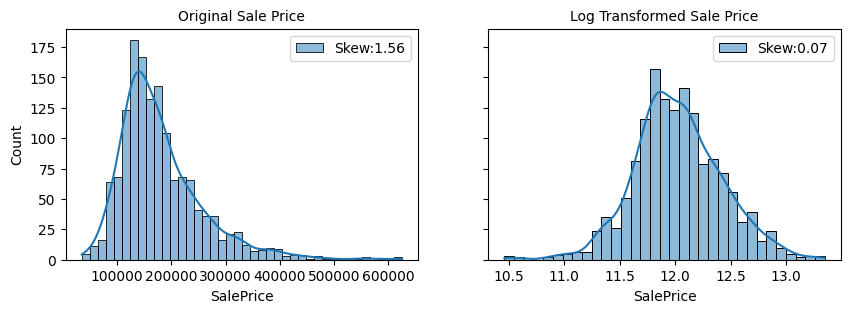

In [4]:
def plot_SL_vs_logSP(train):

    fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,3), sharey = True);
    sns.histplot(ax = ax1, x = train.SalePrice, kde = True, palette = 'crest', 
                 label = "Skew:" + str(round(skew(train.SalePrice),2)));
    ax1.set_title("Original Sale Price", fontsize = 10);
    ax1.legend()
    sns.histplot(ax = ax2, x = np.log1p(train["SalePrice"]), kde = True, palette = 'crest', 
                 label = "Skew:" + str(round(skew(np.log1p(train["SalePrice"])),2)));
    ax2.set_title("Log Transformed Sale Price", fontsize = 10);
    ax2.legend();

plot_SL_vs_logSP(train)

In [5]:
def log_transform(df, feature_list):
    """Log transforming the sales price to correct skew. There should be no missing values in the features 
    to be transformed"""
    
    for feature in feature_list:
        df["ud_log"+feature] = np.log1p(df[feature])
        
    df.drop(feature_list, axis = 1, inplace = True)

    return df

In [6]:
train = log_transform(train, ["SalePrice"])
train.head(2)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,ud_logSalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,12.247699
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,12.109016


### Converting categorical features to ranks

Many of the categorical features in the dataset have a inherent ranking to them. By converting these features to a simple numerical scale, (where higher values are expected to positively impact Sales Price) we eliminate the need to OHE them which inturn reduces the number of numerical variables we need. For these features we also impute the missing values as 0.

Additionally, one numerical feature actually presents categories and so is converted to a categorical feature.

In [7]:
def cat_to_numeric_scale(df):
    """Many of the variables have a categorical scale to them. Converting these to a discrete numerical scale
    ##For details on the values for each feature refer to the Ames dataset documentation"""
    
    features_to_rank = ["ExterQual", "ExterCond", 
                        "BsmtCond", "BsmtQual", "BsmtExposure", "BsmtFinType1", "BsmtFinType2",
                        "HeatingQC", "KitchenQual", 
                        "GarageQual", "GarageCond", 
                        "Street", "Utilities",  "CentralAir",
                        "PavedDrive", "FireplaceQu", "LotShape", "Alley", "Fence", "PoolQC"]
    
    rank_index = {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1,
                  "Gd":4, "Av":3, "Mn": 2, "No": 1, #BsmtExposure
                  "GLQ": 6,"ALQ": 5, "BLQ": 4, "Rec": 3, "LwQ": 2, "Unf": 1, #"BsmtFinType1", "BsmtFinType2"
                  "Grvl": 1, "Pave": 2, #Street, #Alley
                  "AllPub": 4, "NoSewr": 3, "NoSeWa": 2, "ELO": 1, #Utilities
                  "N":0, "P":0, "Y":1, #CentralAir + PavedDrive
                  "MnWw": 1, "GdWo": 2, "MnPrv":3, "GdPrv": 4, #Fence 
                  "IR3":1, "IR2":2, "IR1": 3, "Reg": 4} # LotShape
        
    df[features_to_rank] = df[features_to_rank].replace(rank_index)   #higher values are expected to positively impact Sales Price
    df[features_to_rank] = df[features_to_rank].fillna(0) #where values are missing, assiging score of 0
    
    df["MSSubClass"] = df["MSSubClass"].astype('str')
   
    return df

In [8]:
train = cat_to_numeric_scale(train)
train.head(2)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,ud_logSalePrice
0,1,60,RL,65.0,8450,2,0.0,4,Lvl,4,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,4,3,PConc,4.0,3.0,1.0,6.0,706,1.0,0,150,856,GasA,5,1,SBrkr,856,854,0,1710,1,0,2,1,3,1,4,8,Typ,0,0.0,Attchd,2003.0,RFn,2,548,3.0,3.0,1,0,61,0,0,0,0,0.0,0.0,NaN,0,2,2008,WD,Normal,12.247699
1,2,20,RL,80.0,9600,2,0.0,4,Lvl,4,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,3,3,CBlock,4.0,3.0,4.0,5.0,978,1.0,0,284,1262,GasA,5,1,SBrkr,1262,0,0,1262,0,1,2,0,3,1,3,6,Typ,1,3.0,Attchd,1976.0,RFn,2,460,3.0,3.0,1,298,0,0,0,0,0,0.0,0.0,NaN,0,5,2007,WD,Normal,12.109016


### Missing Value Analysis

One categorical feature "MiscFeature" is missing a large number of values (> 90%). For features that are missing such a large percentage of values, it may not make sense to impute so these are dropped. For other features, if they are numerical, we fill missing values with the median value for simplicity

In [9]:
missing = pd.DataFrame(train.isna().sum().sort_values(ascending = False)/train.shape[0], columns = ["%missing"])
missing[missing["%missing"]>0]

,%missing
MiscFeature,0.962912
MasVnrType,0.598214
LotFrontage,0.177885
GarageFinish,0.055632
GarageType,0.055632
GarageYrBlt,0.055632
MasVnrArea,0.005495
Electrical,0.000687


In [10]:
def missing_impute(df):
    """Dropping variables missing >90% of their values. For the remaining columns with missing values, if numerical,
    we impute with median"""
    
    df = df.loc[:, df.isna().sum()/df.shape[0] <= 0.9]
    
    for col in df.loc[:,df.isna().sum()>0].columns:
        if df[col].dtype in ['int32', 'int64', 'float32', 'float64']:
            df[col].fillna(df[col].median(), inplace = True)
        else: # for categorical features, missing values are removed during ohe (all options set to 0)
            pass
    
    return df

In [11]:
train = missing_impute(train)
train.head(2)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition,ud_logSalePrice
0,1,60,RL,65.0,8450,2,0.0,4,Lvl,4,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,4,3,PConc,4.0,3.0,1.0,6.0,706,1.0,0,150,856,GasA,5,1,SBrkr,856,854,0,1710,1,0,2,1,3,1,4,8,Typ,0,0.0,Attchd,2003.0,RFn,2,548,3.0,3.0,1,0,61,0,0,0,0,0.0,0.0,0,2,2008,WD,Normal,12.247699
1,2,20,RL,80.0,9600,2,0.0,4,Lvl,4,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,3,3,CBlock,4.0,3.0,4.0,5.0,978,1.0,0,284,1262,GasA,5,1,SBrkr,1262,0,0,1262,0,1,2,0,3,1,3,6,Typ,1,3.0,Attchd,1976.0,RFn,2,460,3.0,3.0,1,298,0,0,0,0,0,0.0,0.0,0,5,2007,WD,Normal,12.109016


###  Visual Analysis of Feature - Target Correlation

A visual inspection of the data reveals some features that exhibit a strong linear relationship with the target. There are also some features that where the linear relationship may benefit from a tranforming the underlying data.

In [12]:
numerical_features = [col for col in train.columns[1:] if train[col].dtype in ['int32', 'int64', 'float32', 'float64']]

_ = pd.DataFrame({"abs_corr": abs(train[numerical_features].corr()["ud_logSalePrice"]).sort_values(ascending = False)[1:]})

skew_list = []
type_list = []
for feature in _.index:
    skew_list.append((round(skew(train[feature], nan_policy ='omit'),4)))
    if train[feature].nunique() > 50:
        type_list.append("Continuous")
    else:
        type_list.append("Discrete")
_["abs_skew"] = skew_list
_["feature_type"] = type_list

_.sort_values("abs_corr", ascending = False)

,abs_corr,abs_skew,feature_type
OverallQual,0.819240,0.1837,Discrete
GrLivArea,0.718844,0.8343,Continuous
ExterQual,0.680947,0.8181,Discrete
GarageCars,0.680408,-0.3431,Discrete
KitchenQual,0.667174,0.3810,Discrete
GarageArea,0.655212,0.1329,Continuous
TotalBsmtSF,0.641553,0.4859,Continuous
BsmtQual,0.615225,-1.3003,Discrete
1stFlrSF,0.613742,0.8662,Continuous
FullBath,0.590919,0.0177,Discrete


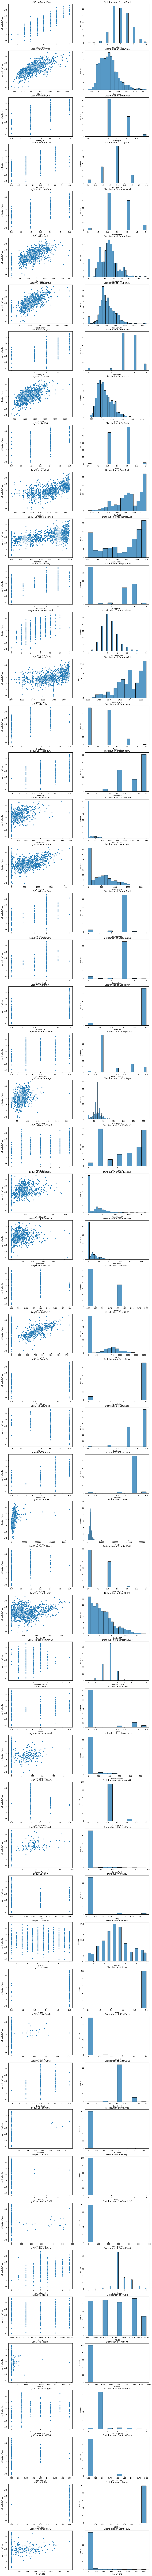

In [13]:
def high_corr_plots(train, col_list):
    fig, axes = plt.subplots(len(col_list),2, figsize = (15, len(col_list)*5));
    ax = axes.ravel()
    count = 0

    for col in col_list:
        sns.scatterplot(ax = ax[count], x = train[col], y = train["ud_logSalePrice"]);
        ax[count].set_title("LogSP vs "+col, fontsize = 12);
        count += 1

        sns.histplot(ax = ax[count], x = train[col], stat = 'percent');
        ax[count].set_title("Distribution of "+ col, fontsize = 12);
        count += 1
        
high_corr_plots(train, _.index)

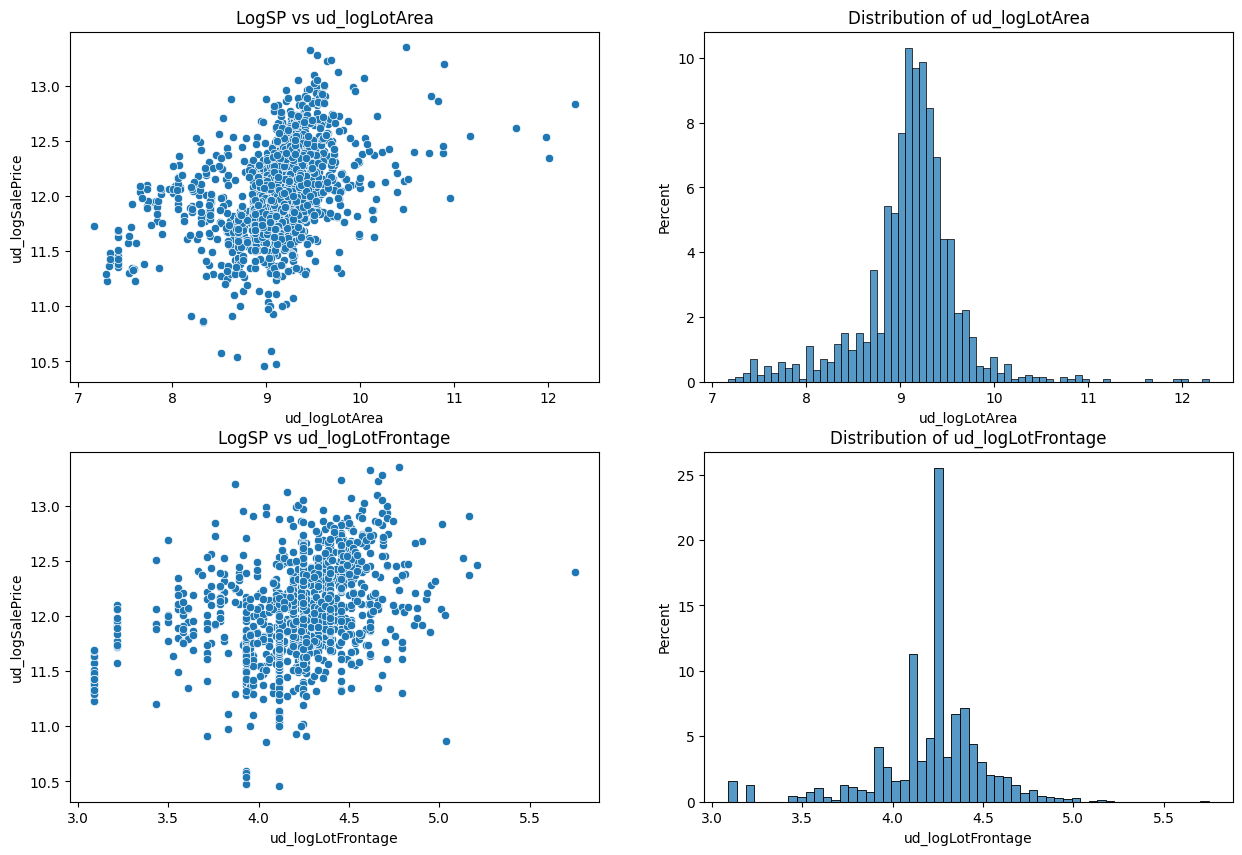

In [14]:
train = log_transform(train, ["LotArea", "LotFrontage"])
high_corr_plots(train, ["ud_logLotArea", "ud_logLotFrontage"])

### OHE for categorical variables

In [15]:
def ohe(df):
    
    categorical_features = [col for col in df.columns if df[col].dtype not in ['int32', 'int64','float32', 'float64']] 
    _ = pd.get_dummies(df[categorical_features])
    df = pd.concat([df, _], axis = 1)
    df.drop(categorical_features, axis = 1, inplace = True)
        
    return df

In [16]:
train = ohe(train)
print(f"The final training dataset has {train.shape[1]} features")

The final training dataset has 239 features


In [17]:
full_Id_list = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv")["Id"] #needed later for the submission file

test = ohe(log_transform(missing_impute(cat_to_numeric_scale(load_data("test.csv"))),["LotArea","LotFrontage"]))
print(f"The final test dataset has {test.shape[1]} features")

The final test dataset has 226 features


### Aligning training and test sets
There is a significant difference between the number of features in the training and test dataset after one hot encoding. One hot encoding creates one new variabe for each value observed in the categorica feature. So the difference in the number of final features is likely because of differences in the values seen in the categorical columns seen in the training vs the test set.

In [18]:
def aligning_train_target(train, test):
    target = train.ud_logSalePrice
    train.drop(["ud_logSalePrice", "Id"], axis = 1, inplace = True)
    
    test_Ids = test.Id
    test.drop("Id", axis = 1, inplace = True)
    
    train, test = train.align(test, join='inner', axis=1)
    
    return target, train, test, test_Ids

In [19]:
target, train, test, test_Ids = aligning_train_target(train, test)
print("Datasets after Alignment")
print(f"training set: {train.shape} and test set: {test.shape}")

Datasets after Alignment
training set: (1456, 224) and test set: (1458, 224)


## Part2: Model Development
### Approach 1 - Linear regression models (regularized)

Given the large number of features in the input data, in the first approach, the data was modeling using regularized linear regression models due to its ability to reduce sensitivity to any individual features. 

For these models, first the appropriate hyperparameter tuning is performed and then Ridge and Lasso techniques are explored

In [20]:
def scaling(train, test):
    
    ##scaling
    ss = RobustScaler().fit(train)
    X_train = ss.transform(train)
    X_test = ss.transform(test)
    
    return X_train, X_test



def param_tuning(X_train, target, model):
    
    ##hyperparameter tuning - finding alpha for the regularized model
    params = {"alpha": [0.0001, 0.001, 0.01, 0.1, 1, 5, 10, 25, 50, 100, 250, 5000, 1000]}
    gs = GridSearchCV(model, param_grid = params, scoring = 'neg_mean_squared_error', n_jobs = -1).fit(X_train, target)
    best_alpha = gs.best_params_['alpha']
    print(f"Best alpha for the model is: {best_alpha}")

    return best_alpha



def model_prediction(X_train, X_test, target, model, test_Ids):
    
    y_hat_train = model.predict(X_train)
    rmse = mean_squared_error(y_hat_train, target, squared = False).round(4)
    print(f"The model produces a rmse score of {rmse} on the training set.")

    y_hat_test = model.predict(X_test)
    submission = pd.DataFrame({'SalePrice': np.exp(y_hat_test)}, index = test_Ids)
    
    return submission



def create_submission_file(submission, full_Id_list, test_Ids):
    
    for i in full_Id_list:
        if i not in list(test_Ids):
            submission.loc[i] = submission.SalePrice.median()

    return submission

### Ridge

In [21]:
X_train, X_test = scaling(train, test)
best_alpha = param_tuning(X_train, target, Ridge())

model = Ridge(alpha = best_alpha).fit(X_train, target)
submission = model_prediction(X_train, X_test, target, model, test_Ids)

submission = create_submission_file(submission, full_Id_list, test_Ids)
# submission.to_csv("approach1_ridge.csv")
print("The model produces a rmse score of 0.1182 on the test set.")

Best alpha for the model is: 10
The model produces a rmse score of 0.0969 on the training set.
The model produces a rmse score of 0.1182 on the test set.


### Lasso

In [22]:
X_train, X_test = scaling(train, test)
best_alpha = param_tuning(X_train, target, Lasso(max_iter = 10000))

model = Lasso(alpha = best_alpha).fit(X_train, target)
submission = model_prediction(X_train, X_test, target, model, test_Ids)

submission = create_submission_file(submission, full_Id_list, test_Ids)
# submission.to_csv("approach1_lasso.csv")
print("The model produces a rmse score of 0.1191 on the test set.")

print("\nOther Key aspects:")
print(f"The lasso model reduces the model features to {model.coef_[abs(model.coef_) >0].shape[0]}, which improves overall model explainability")
_ = pd.DataFrame({"Coef": abs(model.coef_)}, index = test.columns).sort_values("Coef", ascending = False)
_ = _[_["Coef"]>0]
print(f"The top 10 features of this model are: {list(_.head(10).index)}")

Best alpha for the model is: 0.001
The model produces a rmse score of 0.1034 on the training set.
The model produces a rmse score of 0.1191 on the test set.

Other Key aspects:
The lasso model reduces the model features to 74, which improves overall model explainability
The top 10 features of this model are: ['MSZoning_C (all)', 'GrLivArea', 'OverallQual', 'YearBuilt', 'Neighborhood_Crawfor', 'SaleCondition_Abnorml', 'BsmtFinSF1', 'Functional_Typ', 'SaleType_New', 'Exterior1st_BrkFace']


### Approach 2 - Exploring ensemble models

Two ensemble models are explored - RandomForest adn XGBoostRegressor. Both models overfit the training dataset and perform worse on the test set

### RandomForest

In [23]:
X_train, X_test = scaling(train, test)

model = RandomForestRegressor(n_jobs = -1).fit(X_train, target)
submission = model_prediction(X_train, X_test, target, model, test_Ids)

submission = create_submission_file(submission, full_Id_list, test_Ids)
# submission.to_csv("approach2_randomforest.csv")
print("The model produces a rmse score of 0.1421 on the test set.")

The model produces a rmse score of 0.0511 on the training set.
The model produces a rmse score of 0.1421 on the test set.


### XGBRegressor

In [24]:
X_train, X_test = scaling(train, test)

model = XGBRegressor(n_jobs = -1).fit(X_train, target)
submission = model_prediction(X_train, X_test, target, model, test_Ids)

submission = create_submission_file(submission, full_Id_list, test_Ids)
# submission.to_csv("approach2_xgbregressor.csv")
print("The model produces a rmse score of 0.1436 on the test set.")

The model produces a rmse score of 0.01 on the training set.
The model produces a rmse score of 0.1436 on the test set.


### Approach 3 - Using SelectPercentile to further reduce dimensionality (to improve model explainability)

In [25]:
X_train, X_test = scaling(train, test)

sp = SelectPercentile(f_regression, percentile = 50).fit(X_train, target)
X_train_subset = sp.transform(X_train)
X_test_subset = sp.transform(X_test)
sp.get_support()
features_used = pd.Series(sp.get_support(), index = train.columns)  #loc[:,sp.get_support()].columns
features_used = features_used[features_used == True].index
print(f"Feature selection based on SelectPercentile reduced the initial set of features to {len(features_used)}")

Feature selection based on SelectPercentile reduced the initial set of features to 112


In [26]:
#Ridge
best_alpha = param_tuning(X_train_subset, target, Ridge())
model = Ridge(alpha = best_alpha).fit(X_train, target)
submission = model_prediction(X_train, X_test, target, model, test_Ids)

submission = create_submission_file(submission, full_Id_list, test_Ids)
# submission.to_csv("approach3_ridge.csv")
print("The model produces a rmse score of 0.11975 on the test set.")  #No improvement compared to the original ridge model

Best alpha for the model is: 5
The model produces a rmse score of 0.0951 on the training set.
The model produces a rmse score of 0.11975 on the test set.


In [27]:
#Lasso
best_alpha = param_tuning(X_train_subset, target, Lasso(max_iter = 10000))
model = Lasso(alpha = best_alpha).fit(X_train_subset, target)
submission = model_prediction(X_train_subset, X_test_subset, target, model, test_Ids)

submission = create_submission_file(submission, full_Id_list, test_Ids)
# submission.to_csv("approach3_lasso.csv")
print("The model produces a rmse score of 0.13015 on the test set.")  #Deteriorating in performance compared to original Lasso model

print("\nOther Key aspects:")
print(f"The lasso model reduces the model features to {model.coef_[abs(model.coef_) >0].shape[0]}, which improves overall model explainability")
_ = pd.DataFrame({"Coef": abs(model.coef_)}, index = features_used).sort_values("Coef", ascending = False)
_ = _[_["Coef"]>0]
print(f"The top 10 features of this model are: {list(_.head(10).index)}")

Best alpha for the model is: 0.0001
The model produces a rmse score of 0.1045 on the training set.
The model produces a rmse score of 0.13015 on the test set.

Other Key aspects:
The lasso model reduces the model features to 92, which improves overall model explainability
The top 10 features of this model are: ['MSZoning_C (all)', 'Functional_Maj2', 'GrLivArea', 'OverallQual', 'Heating_Grav', 'Neighborhood_MeadowV', 'Functional_Typ', 'SaleCondition_Abnorml', 'Neighborhood_StoneBr', 'Exterior1st_Wd Sdng']


#### Approach 4 - Using SelectFromModel to further reduce dimensionality (to improve model explainability)

No significant gains

In [28]:
X_train, X_test = scaling(train, test)

sp = SelectFromModel(RandomForestRegressor(random_state = 0, n_jobs = -1), threshold="median").fit(X_train, target)
# # sp = SelectFromModel(XGBRegressor(random_state = 0, n_jobs = -1), threshold="median").fit(X_train, y_train)
X_train_subset = sp.transform(X_train)
X_test_subset = sp.transform(X_test)
sp.get_support()
features_used = pd.Series(sp.get_support(), index = train.columns)  #loc[:,sp.get_support()].columns
features_used = features_used[features_used == True].index
print(f"Feature selection based on SelectFromModel reduced the initial set of features to {len(features_used)}")

Feature selection based on SelectFromModel reduced the initial set of features to 112


In [29]:
#Ridge
best_alpha = param_tuning(X_train_subset, target, Ridge())
model = Ridge(alpha = best_alpha).fit(X_train, target)
submission = model_prediction(X_train, X_test, target, model, test_Ids)

submission = create_submission_file(submission, full_Id_list, test_Ids)
# submission.to_csv("approach4_ridge.csv")
print("The model produces a rmse score of 0.1182 on the test set.")  #No improvement compared to the original ridge model

Best alpha for the model is: 10
The model produces a rmse score of 0.0969 on the training set.
The model produces a rmse score of 0.1182 on the test set.


In [31]:
#Lasso
best_alpha = param_tuning(X_train_subset, target, Lasso())
model = Lasso(alpha = best_alpha).fit(X_train_subset, target)
submission = model_prediction(X_train_subset, X_test_subset, target, model, test_Ids)

submission = create_submission_file(submission, full_Id_list, test_Ids)
submission.to_csv("submission.csv") ##approach4_lasso
print("The model produces a rmse score of 0.11993 on the test set.")


print("\nOther Key aspects:")
print(f"The lasso model reduces the model features to {model.coef_[abs(model.coef_) >0].shape[0]}, which improves overall model explainability")
_ = pd.DataFrame({"Coef": abs(model.coef_)}, index = features_used).sort_values("Coef", ascending = False)
_ = _[_["Coef"]>0]
print(f"The top 10 features of this model are: {list(_.head(10).index)}")

Best alpha for the model is: 0.001
The model produces a rmse score of 0.1049 on the training set.
The model produces a rmse score of 0.11993 on the test set.

Other Key aspects:
The lasso model reduces the model features to 66, which improves overall model explainability
The top 10 features of this model are: ['MSZoning_C (all)', 'GrLivArea', 'OverallQual', 'YearBuilt', 'Neighborhood_Crawfor', 'SaleCondition_Abnorml', 'BsmtFinSF1', 'Functional_Typ', 'SaleType_New', 'TotalBsmtSF']


<!-- #### Part 3C - Feature selection to improve model explainability - using RFE

ARFE - significant improvement using randomforest and slight improvement with xgboost -->

#### Final model chosen is Lasso with initial felection using Random Forest - (Approach 4B). This model is chosen over the original model due to reduction in the number of final model features used which improves model explainability

### Useful Links
I learnt a lot from the following notebooks:

https://www.kaggle.com/code/jesucristo/1-house-prices-solution-top-1

https://www.kaggle.com/code/juliencs/a-study-on-regression-applied-to-the-ames-dataset

https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/discussion/210174

https://www.kaggle.com/discussions/getting-started/50008#284798